In [153]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pandas_profiling import ProfileReport
from matplotlib import patches, colors, cm

data = pd.read_csv("train.csv")

Remove the inconsistency in flat_type

In [158]:

data['flat_type'] = data.flat_type.replace(to_replace= '\s', value= '-', regex=True)
print(data['flat_type'].unique())
mapping = {'1-room': 1, '2-room': 2, '3-room': 3, '4-room': 4, '5-room': 5, 'multi-generation': 6, 'executive': 7}
data['flat_type_number'] = data['flat_type'].map(mapping)

grouping_result = data.groupby(['flat_type'])['resale_price'].mean().to_dict()
print(grouping_result)
data['flat_type_price'] = data['flat_type'].map(grouping_result)


['4-room' '5-room' '3-room' 'executive' '2-room' 'multi-generation'
 '1-room']
{'1-room': 111137.31188811189, '2-room': 161399.29816452897, '3-room': 209623.2405061207, '4-room': 297586.6883694228, '5-room': 381620.3227795678, 'executive': 457137.96053217823, 'multi-generation': 516351.54162162164}


Get an initial profile of the dataset

In [ ]:
# profile = ProfileReport(data)
# profile

In [ ]:
# temporary attributes
data['price_psm'] = data['resale_price']/data['floor_area_sqm']
data['datetime'] = pd.to_datetime(data.month)

eco_category and elevation are useless

In [ ]:
data = data.drop(columns=['eco_category', 'elevation'])

We can clearly see that the transaction year has impact on price. Resale price grew fast from 2005 to 2012 and stabalised after 2012.  
Normalise month starting from baseline year 2000.

datetime
2000    234005.834827
2001    220758.425492
2002    212077.136355
2003    209368.441467
2004    212668.493249
2005    211206.148834
2006    213030.979954
2007    236767.140391
2008    286153.241698
2009    304723.922966
2010    342673.956933
2011    383067.039190
2012    415717.664354
2013    428608.627490
2014    398509.079228
2015    391025.954819
2016    395380.941080
2017    399855.146120
2018    396508.217688
2019    388650.256729
2020    403828.632992
Name: resale_price, dtype: float64

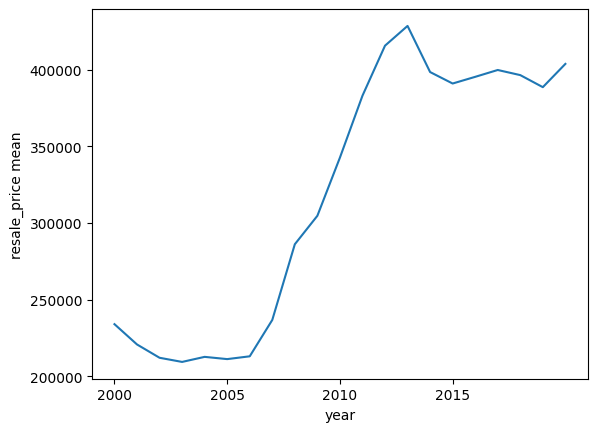

In [ ]:
display(data.groupby(data['datetime'].dt.year)['resale_price'].mean())
data.groupby(data['datetime'].dt.year)['resale_price'].mean().plot(kind='line', xlabel='year' ,ylabel='resale_price mean', xticks=np.arange(2000, 2020, 5))
plt.show()
data['month'] = (data['datetime'].dt.year - 2000) * 12 + data['datetime'].dt.month

Transform lease commence date to remaining lease years. One important factor determining resale price is the length of remaining lease. Longer remaining lease correlates to higher price.

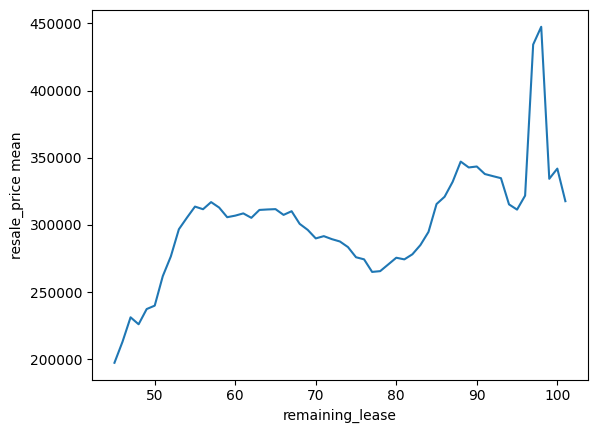

In [ ]:
data['remaining_lease'] = data['lease_commence_date'] + 99 - data['datetime'].dt.year
# data = data.drop(columns='lease_commence_date')
data.groupby(data['remaining_lease'])['resale_price'].mean().plot(kind='line', ylabel='resale_price mean')
plt.show()

Storey range has two scales: 3 or 5. Records with scale of 5 make up around 1% data.  
As shown in the following figures, higher floor correlates with higher price.  
We notice that data with storey_range of scale 5 has higher price across almost all levels. Those transactions happened only in 2012, and the mean transaction time is around 36 months later, which explains the difference. In storey_range categories where the mean transaction time is earlier, the average price is lower.

['01 to 03' '01 to 05' '04 to 06' '06 to 10' '07 to 09' '10 to 12'
 '11 to 15' '13 to 15' '16 to 18' '16 to 20' '19 to 21' '21 to 25'
 '22 to 24' '25 to 27' '26 to 30' '28 to 30' '31 to 33' '31 to 35'
 '34 to 36' '36 to 40' '37 to 39' '40 to 42' '43 to 45' '46 to 48'
 '49 to 51']
Number of records of scale 3: 426261
Number of records of scale 5: 5471


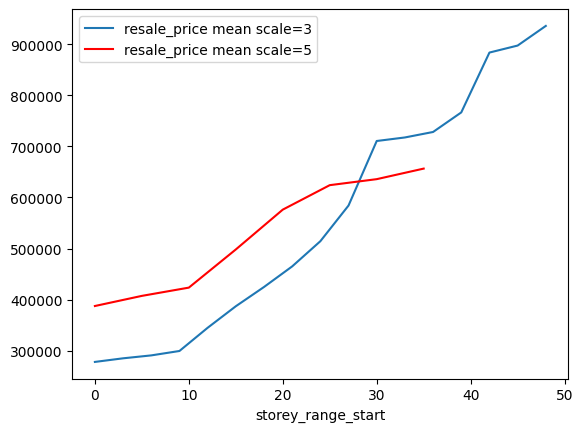

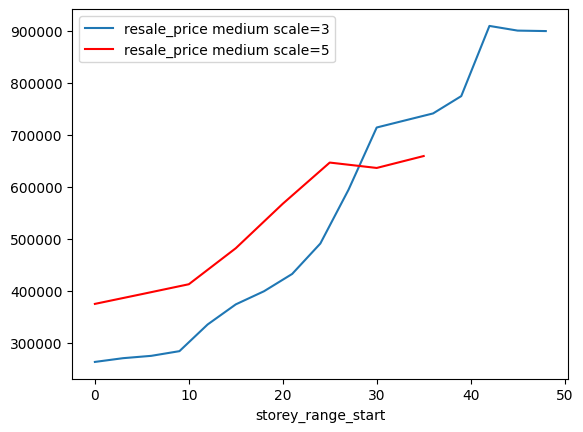

month                     111.662310
floor_area_sqm             96.965728
lease_commence_date      1989.417007
latitude                    1.364920
longitude                 103.836515
resale_price           300439.115315
flat_type_number            4.141990
price_psm                3108.964822
remaining_lease            79.662749
storey_range_start          5.742995
storey_range_end            8.742995
dtype: float64

month                     148.003838
floor_area_sqm             97.307841
lease_commence_date      1989.732407
latitude                    1.366427
longitude                 103.834723
resale_price           409376.133100
flat_type_number            4.199415
price_psm                4283.270330
remaining_lease            76.732407
storey_range_start          4.636264
storey_range_end            9.636264
dtype: float64

Year range scale=5 : 2012-03-01 00:00:00 - 2012-05-01 00:00:00


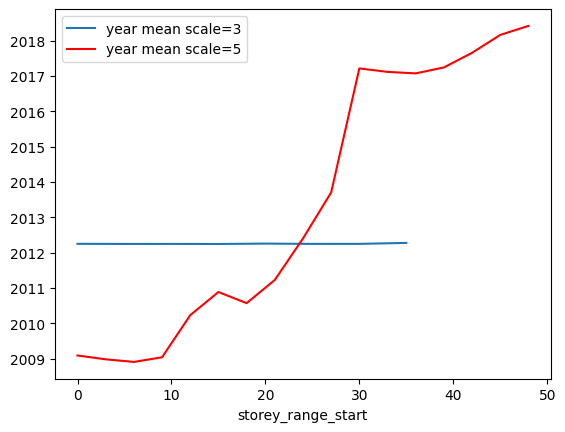

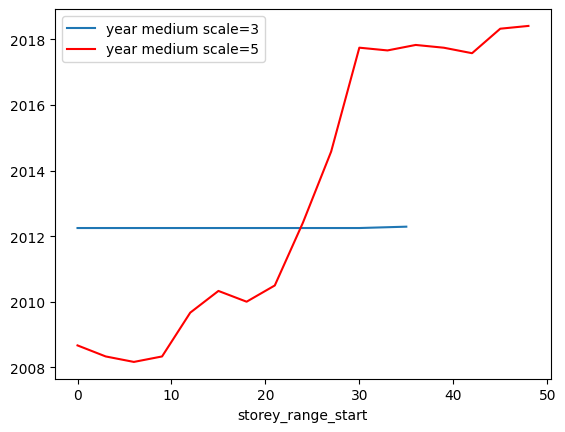

In [ ]:
storeys = data.storey_range.unique()
storeys.sort()
print(storeys)

data['storey_range_start'] = data['storey_range'].str[:2].astype('int') - 1
data['storey_range_end'] = data['storey_range'].str[6:].astype('int')

scale3 = data[(data['storey_range_end'] - data['storey_range_start']) == 3]
scale5 = data[(data['storey_range_end'] - data['storey_range_start']) == 5]
print(f'Number of records of scale 3: {scale3.index.size}')
print(f'Number of records of scale 5: {scale5.index.size}')

ax1 = scale3.groupby(['storey_range_start'])['resale_price'].mean().plot(kind="line", label= 'resale_price mean scale=3')
ax2 = scale5.groupby(['storey_range_start'])['resale_price'].mean().plot(kind="line", label= 'resale_price mean scale=5', color='r')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(l1 + l2, loc=2)
plt.show()
ax1 = scale3.groupby(['storey_range_start'])['resale_price'].median().plot(kind="line", label = 'resale_price medium scale=3')
ax2 = scale5.groupby(['storey_range_start'])['resale_price'].median().plot(kind="line", label= 'resale_price medium scale=5', color='r')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(l1 + l2, loc=2)
plt.show()

display(scale3.mean(axis=0, numeric_only=True))
display(scale5.mean(axis=0, numeric_only=True))
print(f'Year range scale=5 : {scale5.datetime.min()} - {scale5.datetime.max()}')

# following code plots the transaction year of the two groups
ax1 = scale5.groupby(['storey_range_start'])['datetime'].mean().plot(kind="line", label = 'year mean scale=3')
ax2 = scale3.groupby(['storey_range_start'])['datetime'].mean().plot(kind="line", label = 'year mean scale=5', color = 'r')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(l1 + l2, loc=2)
plt.show()
ax1 = scale5.groupby(['storey_range_start'])['datetime'].median().plot(kind="line", label = 'year medium scale=3')
ax2 = scale3.groupby(['storey_range_start'])['datetime'].median().plot(kind="line", label = 'year medium scale=5', color = 'r')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(l1 + l2, loc=2)
plt.show()

There are a few options to process the incompatible scale:
- merge to closest
- merge to 15
- target encoding
Storey_range actually contains useful information. Merging it to group of 15 storeys or target-encoding it will lose this piece of information. Merging it to closest group is the most suitable processing

In [ ]:
data['storey_range_processed'] = np.ceil(data['storey_range_start'] / 3)
# data = data.drop(columns=['storey_range', 'storey_range_start', 'storey_range_end'])

20 flat models. Choices during training:
- label encoding
- merge categories

20


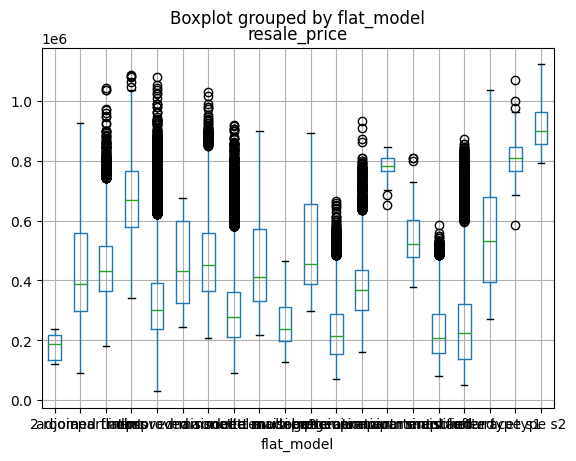

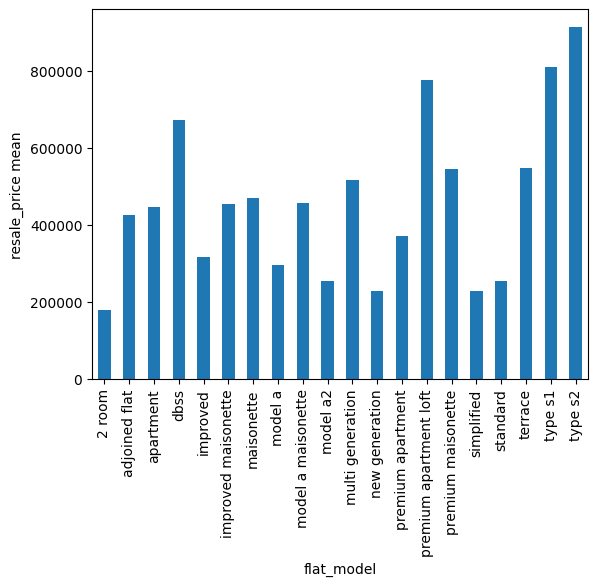

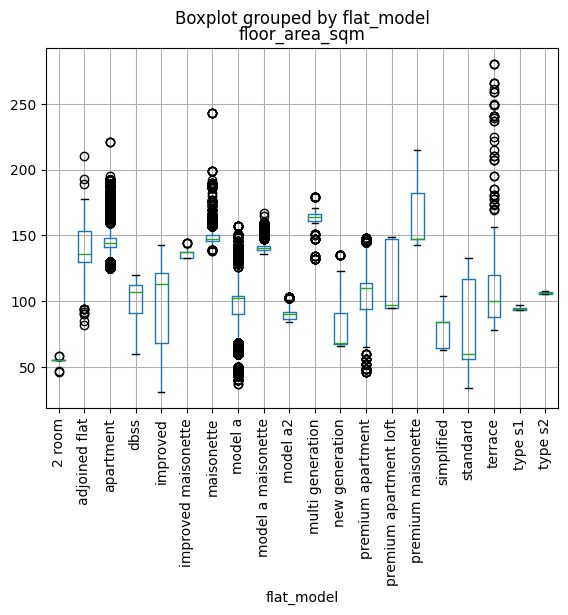

In [ ]:
print(data['flat_model'].unique().size)
data.boxplot(by='flat_model', column='resale_price')
plt.show()
data.groupby(['flat_model'])['resale_price'].mean().plot(kind='bar', ylabel='resale_price mean')
plt.show()
data.boxplot(by='flat_model', column='floor_area_sqm')
plt.xticks(rotation=90)
plt.show()

Transform latitude and longitude and put records into 1 km grid. Then calculate the average transaction price and price per square metre.

In [162]:
data['min_lat'] = data['latitude'].min()
data['min_lon'] = data['longitude'].min()

# create points from lat and long, and corresponding points on x and y axis
# points = data.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
# x_points = data.apply(lambda x: Point(x['longitude'], minLat), axis=1)
# y_points = data.apply(lambda x: Point(minLon, x['latitude']), axis=1)
# init and tell geopandas this is lat, long coordinates
geodata = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(data['longitude'], data['latitude']), crs='EPSG:4326')
x_data = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(data['longitude'], data['min_lat']), crs='EPSG:4326')
y_data = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(data['min_lon'], data['latitude']), crs='EPSG:4326')
# transform coordinate so that can exact distance (in km) can be calculated
geodata.to_crs(epsg=3414, inplace=True)
x_data.to_crs(epsg=3414, inplace=True)
y_data.to_crs(epsg=3414, inplace=True)

# calculate distance
#adjust grid size if necessary
data['x_grid'] = (geodata.distance(y_data) / 1000).astype('int')
data['y_grid'] = (geodata.distance(x_data) / 1000).astype('int')

print(data.groupby(['x_grid', 'y_grid']).size().min())

mapping = data.groupby(["x_grid", "y_grid"])['resale_price'].mean().to_dict()
# print(mapping)
from typing import Tuple
data["grid_price"] = data[["x_grid", "y_grid"]].agg(tuple, 1).map(mapping)
# data["grid_price"] = data[["x_grid", "y_grid"]].map(mapping)

# data['grid_price'] = data.groupby(['x_grid', 'y_grid'])['resale_price'].transform("mean")
# data['grid_price_psm'] = data.groupby(['x_grid', 'y_grid'])['price_psm'].transform("mean")

14
{(0, 7): 246401.22564356436, (0, 8): 265404.33011968085, (1, 7): 343906.05800293793, (1, 8): 292136.20946854056, (1, 9): 313504.6127819549, (2, 7): 336751.49362990656, (2, 8): 279944.2042317573, (2, 9): 336941.7157894737, (3, 6): 280977.71186440677, (3, 7): 283737.1404990403, (3, 8): 227680.62676579924, (3, 9): 287856.8112217194, (4, 6): 336310.1145499383, (4, 7): 268186.68667790893, (4, 8): 245275.51360103628, (4, 9): 280998.1414405987, (5, 5): 282609.0, (5, 7): 260297.37490272374, (5, 8): 259486.51421255353, (5, 11): 291189.2873438141, (5, 12): 280028.806626506, (6, 5): 225898.07755572634, (6, 7): 326810.38836182107, (6, 8): 280600.9210048087, (6, 9): 225853.96695652173, (6, 10): 221988.92284826323, (6, 11): 302360.48501026694, (6, 12): 292139.16434310295, (6, 13): 326510.43937093276, (6, 14): 319948.9957317073, (7, 5): 263541.76767123287, (7, 8): 264395.0590880829, (7, 9): 240985.54670217124, (7, 10): 306917.86547619046, (7, 11): 242325.986935867, (7, 12): 254564.60498855833, (7,

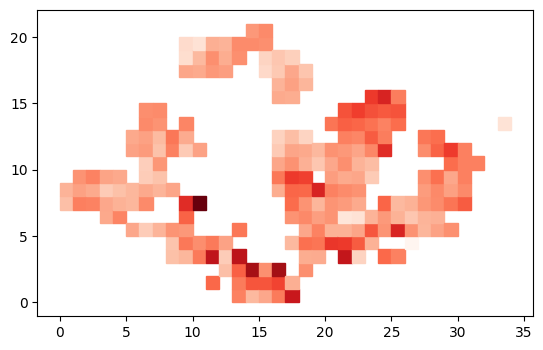

In [ ]:
meanPriceGroup = data.groupby(['x_grid', 'y_grid'])['resale_price'].mean()

fig1 = plt.figure()
ax = fig1.add_subplot()
# do nothing
ax.plot(0, 0, 'wo')

minima = meanPriceGroup.min()
maxima = meanPriceGroup.max()

norm = colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
mapper_list = [mapper.to_rgba(x) for x in meanPriceGroup]

for i, index in enumerate(meanPriceGroup.index):
    ax.add_patch(patches.Rectangle(index, 1, 1, color = mapper_list[i]))

ax.set_aspect('equal', adjustable='box')
plt.show()

lease_commence_date
2019       2
2018       2
1966      21
2017      40
1991     543
2007     612
2010     828
1968     830
2009    1060
2008    1313
dtype: int64

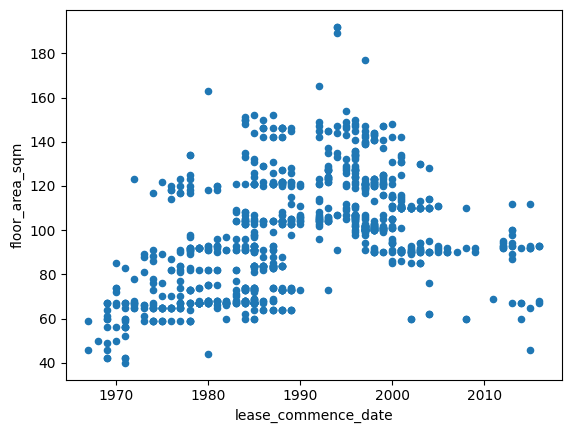

<AxesSubplot: xlabel='lease_commence_date', ylabel='floor_area_sqm'>

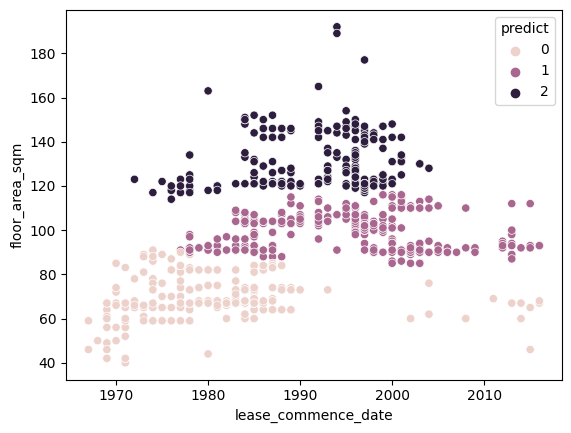

In [ ]:
'''Clustering'''
from sklearn.cluster import KMeans
import seaborn
display(data.groupby(['lease_commence_date']).size().sort_values().head(10))

sample = data.sample(n= 1000, axis=0).copy(deep=True).reset_index()
sample.plot.scatter(x='lease_commence_date', y='floor_area_sqm')
plt.show()
# sample.plot.scatter(x='lease_commence_date', y='price_psm')
# plt.show()

lease_area = data[['lease_commence_date', 'floor_area_sqm']].to_numpy()
kmeans = KMeans(n_clusters=3, n_init=10).fit(lease_area)
result = kmeans.predict(sample[['lease_commence_date', 'floor_area_sqm']].to_numpy()).reshape((-1, 1))
result = pd.DataFrame(result)
result.columns = ['predict']
sample = sample.join(result)
seaborn.scatterplot(data=sample, x='lease_commence_date', y='floor_area_sqm', hue='predict')